#### IMPORTS

In [780]:
from typing import Union, Tuple
import numpy as np
import random
import matplotlib.pyplot as mtp
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize

from hyperopt import hp, fmin, Trials, STATUS_OK

#### PARAMS

In [781]:
FILE_NAME = 3

spaceMNK = {
    'tau': hp.loguniform('tau', -9, 0)
}

spaceSGD = {
    'tau': hp.loguniform('tau', -9, 0),
    'mu': hp.loguniform('mu', -1, 0),
    'damp': hp.loguniform('damp', -1, 0),
    'l': hp.loguniform('l', -2, 0),
}

#### DATA

In [782]:
def get_data(file_name: Union[int, str]) -> (
        float,
        Tuple[int, np.ndarray, np.ndarray],
        Tuple[int, np.ndarray, np.ndarray]
):
    with open("data/%s.txt" % str(file_name), "r") as reader:
        def read_matrix():
            size = int(next(reader))
            matrix = normalize(np.array([[float(num) for num in next(reader).split()] for _ in range(size)]))
            x, y = matrix[:, :-1], matrix[:, -1]
            return size, x, y

        return int(next(reader)), read_matrix(), read_matrix()

#### METRICS

In [783]:
def get_smape(y_trained: np.ndarray, y_test: np.ndarray) -> float:
    return sum([np.abs(a - b) / (np.abs(a) + np.abs(b)) for (a, b) in zip(y_trained, y_test)]) / len(y_trained)


def get_mse(y_trained: np.ndarray, y_test: np.ndarray) -> float:
    return mean_squared_error(y_test, y_trained)


error_1 = {
    "smape": lambda predict, real: np.abs(predict - real) / (np.abs(predict) + np.abs(real)),
    "mse": lambda predict, real: (predict - real) ** 2,
}


def get_nrmse(y_trained: np.ndarray, y_test: np.ndarray) -> float:
    return np.sqrt(get_mse(y_test, y_trained)) / (np.max(y_test) - np.min(y_test))


def produce(x: np.ndarray, w: np.ndarray) -> np.ndarray:
    return np.array([vec @ w for vec in x])


def get_errors(x_test: np.ndarray, y_test: np.ndarray, w: np.ndarray):
    y_trained = produce(x_test, w)
    smape = get_smape(y_trained, y_test)
    nrmse = get_nrmse(y_trained, y_test)
    mse = get_mse(y_trained, y_test)
    return smape, mse, nrmse


#### MNK

In [784]:
def mnk(x: np.ndarray, y: np.ndarray, tau: float) -> np.ndarray:
    _x_T = x.T
    _E = np.identity(_x_T.shape[0])
    return np.linalg.inv(_x_T @ x + tau * _E) @ _x_T @ y


def solve_mnk(x_train: np.ndarray, y_train: np.ndarray,
              x_test: np.ndarray, y_test: np.ndarray,
              tau: float) -> (float, float, float):
    w = mnk(x_train, y_train, tau)
    return get_errors(x_test, y_test, w)

#### GRADIENT DESCENT

In [785]:
def gradient_descent(
        error_minimization: str,
        xs: np.ndarray,
        ys: np.ndarray,
        tau: float,
        mu: float,
        damp: float,
        l: float,
        draw_q: bool = False
) -> (np.ndarray, float):
    n = len(xs)
    bound = 1 / (2 * n)
    w = np.array([random.uniform(-bound, bound) for _ in range(len(xs[0]))])
    q = get_mse(produce(xs, w), ys)
    random.seed(42)
    q_s = [q]
    for k in range(1, 2000):
        mu *= damp
        i = random.randint(0, n - 1)
        grad = gradient[error_minimization](w, xs[i], ys[i])
        w -= mu * (grad + tau * w)

        q_prev = q
        q = (1 - l) * q + l * error_1[error_minimization](xs[i] @ w, ys[i])
        q_s.append(q)
        if np.abs(q_prev - q) < 1e-7:
            break

    if draw_q:
        mtp.plot(q_s, label='q')
        mtp.legend()
        mtp.show()
    return w


def gradient_smape(w: np.ndarray, x: float, y: float) -> np.ndarray:
    y_predicted = w @ x
    grad = - 2 * x * y / (y_predicted + y) ** 2
    if 0 > y > y_predicted or 0 < y < y_predicted:
        grad = -grad
    return grad


gradient = {
    "smape": gradient_smape,
    "mse": lambda w, x, y: 2 * (w @ x - y) * x
}


def solve_gradient_descent(
        error_minimization: str,
        x_train: np.ndarray, y_train: np.ndarray,
        x_test: np.ndarray, y_test: np.ndarray,
        tau: float, mu: float, damp: float, l: float, draw_q: bool = False
):
    w = gradient_descent(error_minimization, x_train, y_train, tau=tau, mu=mu, damp=damp, l=l, draw_q=draw_q)
    return get_errors(x_test, y_test, w)

#### DRAW

In [786]:
def draw_line(x: np.ndarray, y: np.ndarray, xlabel: str, ylabel: str, label: str = ''):
    mtp.plot(x, y, label=label)
    mtp.xlabel(xlabel)
    mtp.ylabel(ylabel)
    mtp.legend()
    mtp.show()


#### SMAPE and MSE for MNK

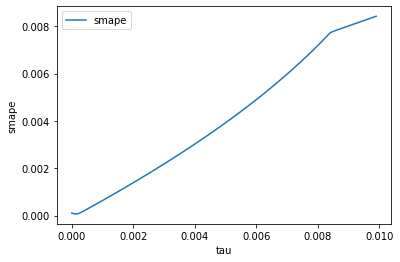

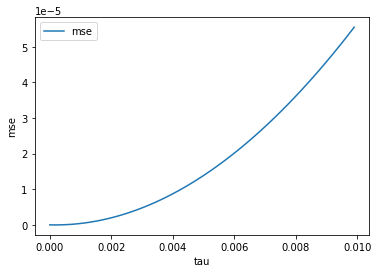

In [787]:
def draw_mnk():
    m, train_data, test_data = get_data(FILE_NAME)
    n_train, x_train, y_train = train_data
    n_test, x_test, y_test = test_data

    theta_s, smape_s, mse_s = [], [], []
    for tau in np.arange(1e-9, 1e-2, 1e-4):
        smape, mse, _ = solve_mnk(x_train, y_train, x_test, y_test, tau=tau)
        theta_s.append(tau)
        smape_s.append(smape)
        mse_s.append(mse)
    draw_line(theta_s, smape_s, xlabel='tau', ylabel='smape', label='smape')
    draw_line(theta_s, mse_s, xlabel='tau', ylabel='mse', label='mse')


draw_mnk()

#### MAIN

TPE is being used as the default algorithm.


100%|██████████| 150/150 [00:00<00:00, 270.51trial/s, best loss: 6.800868407626847e-05]

TPE is being used as the default algorithm.



BEST MNK SMAPE: {'tau': 0.00016182305828894974}
100%|██████████| 150/150 [00:00<00:00, 287.99trial/s, best loss: 7.562659358382597e-05]

TPE is being used as the default algorithm.



BEST MNK NRMSE: {'tau': 0.00017889559505133632}
100%|██████████| 150/150 [00:06<00:00, 22.54trial/s, best loss: 5.08816243652378e-05] 
BEST GRAD SMAPE: {'damp': 0.8952221830595559, 'l': 0.7969338156231821, 'mu': 0.7570451580011367, 'tau': 0.005867496196363717}


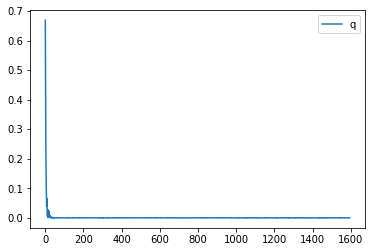

TPE is being used as the default algorithm.


100%|██████████| 150/150 [00:04<00:00, 33.64trial/s, best loss: 0.0018705953822797437]
BEST GRAD NRMSE: {'damp': 0.9990540181989825, 'l': 0.2832630894591356, 'mu': 0.8272509951567865, 'tau': 0.00012366331111097076}


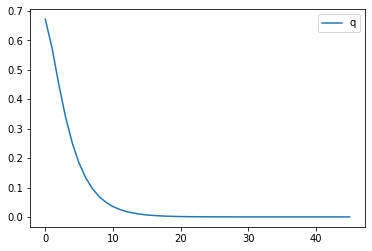

In [788]:
def main():
    m, train_data, test_data = get_data(FILE_NAME)
    n_train, x_train, y_train = train_data
    n_test, x_test, y_test = test_data

    def best_mnk(index):
        def solve(hyper_params):
            errors = solve_mnk(x_train, y_train, x_test, y_test, **hyper_params)
            return {'loss': errors[index], 'status': STATUS_OK}

        return solve

    def best_grad(error_minimization, index):
        def solve(hyper_params):
            errors = solve_gradient_descent(error_minimization, x_train, y_train, x_test, y_test, **hyper_params)
            return {'loss': errors[index], 'status': STATUS_OK}

        return solve

    trials_mnk_smape = Trials()
    print("BEST MNK SMAPE:", fmin(fn=best_mnk(0), space=spaceMNK, max_evals=150, trials=trials_mnk_smape))

    trials_mnk_nrmse = Trials()
    print("BEST MNK NRMSE:", fmin(fn=best_mnk(2), space=spaceMNK, max_evals=150, trials=trials_mnk_nrmse))

    trials_grad_smape = Trials()
    best_smape = fmin(fn=best_grad("smape", 0), space=spaceSGD, max_evals=150, trials=trials_grad_smape)
    print("BEST GRAD SMAPE:", best_smape)
    solve_gradient_descent("smape", x_train, y_train, x_test, y_test,
                           tau=best_smape["tau"],
                           mu=best_smape["mu"],
                           damp=best_smape["damp"],
                           l=best_smape["l"],
                           draw_q=True
                           )

    trials_grad_nrmse = Trials()
    best_nrmse = fmin(fn=best_grad("mse", 2), space=spaceSGD, max_evals=150, trials=trials_grad_nrmse)
    print("BEST GRAD NRMSE:", best_nrmse)
    solve_gradient_descent("mse", x_train, y_train, x_test, y_test,
                           tau=best_nrmse["tau"],
                           mu=best_nrmse["mu"],
                           damp=best_nrmse["damp"],
                           l=best_nrmse["l"],
                           draw_q=True
                           )


main()
